## CMPE 462 HOMEWORK 3

In [9]:
# Allowed Libraries
import numpy as np
import matplotlib.pyplot as plt

# Multilayered Perceptron
**Target:** Implement multi-layer perceptron and analyze the results

**Data:**  The dataset (points2d.dat) is attached to the email. The sample includes 400 instances. Each instance is represented by a feature vector of 2 dimensions. The third column corresponds to the class (0/1/2) of the instance.

- Report how you split the sample for training and test. Report how you designed your neural network to solve this 3-class problem.(number of layers, error function etc.)
- Derive weight update equations using hyperbolic tangent activation function for hidden layers and sigmoid activation function for output layer . Submit a hard-copy of this derivation, drawing the the corresponding neural network with hidden units. All the formulas and the corresponding symbols should be clear. 
- Implement multi-layer perceptron with 5 hidden units. While training at each iteration, plot the error on training and test sets.
- After training converges: Plot the validation/test set and show true positives, true negatives,false positives, and false negatives (with different markers, colors, etc.)

Read the data and form x, y and classes set. This is just the raw data and train set and test set will be formed later

In [10]:
data = np.genfromtxt('points2d.dat', dtype=None, delimiter=' ')
x = [data[i][0] for i in range(len(data))]
y = [data[i][1] for i in range(len(data))]
classes = [data[i][2] for i in range(len(data))]
classes = [[int(x / 2), x % 2] for x in classes]
points = [[x[i], y[i]] for i in range(len(x))]

## Neuron
Neuron class that will be used as the neuron, the smallest component of the network.
Has bias, weights array and layer type as variables. Performs neurons actions.

If hidden layer neuron, activation function is tanh.

If output layer neuron, activation function is sigmoid.

In [11]:
class Neuron:
    def __init__(self, layer_type, bias=0):
        self.bias = bias
        self.weights = []
        self.layer_type = layer_type   # either hidden or output

    def calculate_output(self, inputs):		# calculates output by finding weighted sum of all the inputs and squashing it
        self.inputs = inputs
        if self.layer_type == 'output':
            self.output = self.squash_with_sigmoid(self.calculate_net())
        elif self.layer_type == 'hidden':
            self.output = self.squash_with_tanh(self.calculate_net())
        return self.output

    def squash_with_tanh(self, net):		# squashes net of the neuron using tanh function that returns [-1,1]
        return np.tanh(net)

    def squash_with_sigmoid(self, net):		# squashes net of the neuron using sigmoid function
        return self.sigmoid(net)

    def sigmoid(self, x):					# sigmoid function that returns [0,1]
        return (1 / (1 + np.exp(-x)))

    def calculate_net(self):				# calculates the net of the neuron
        net = 0.0
        for i in range(0, len(self.inputs)):
            net += (self.inputs[i] * self.weights[i])
        net = net + self.bias
        return net

    def calculate_delta(self, desired_output):		# calculates delta, used only for the output layer neurons 
        return (desired_output - self.output) * (-1) * self.output * (1 - self.output)
        #return (desired_output - self.output) * (-1) * (1 - self.output * self.output)	

    def calculate_error(self, desired_output):
        return (desired_output - self.output) * (desired_output - self.output) / 2

## Layer
Layer class is the layer of the network which has neurons array, bias and layer type as variables. Performs layer's actions.

In [12]:
# Layer of the network which consists of neurons
class Layer:
    def __init__(self, neuron_number, layer_type, bias=0):
        self.bias = bias
        self.neurons = []
        self.layer_type = layer_type   # either hidden or output
        for i in range(0, neuron_number):
            self.neurons.append(Neuron(layer_type, self.bias))

    def initialize_weights(self, input_number):		# initializes weights of the neurons randomly with gaussian distribution with mean = 0 and standard deviation = 1
        for neuron in self.neurons:
            for i in range(0, input_number):
                neuron.weights.append(np.random.normal(-0.5,0.5))

    def feed_forward(self, inputs):					# feed forward in the layer, find outputs off all the neurons in the layer
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

## Network
Network is the main class of the network, it is the network itself. It has alpha as the learning rate, hidden layer and output layer as variables. It performs network's actions.

As there are 2 inputs, network also has 2 input neurons. As stated in the description, network also has 5 hidden neurons whose activation function is tanh. Finally, as there are 3 classes to distinguish from, there are 2 output neurons. Class 0 is labeled as [0,0], class 1 as [0,1] and class 2 as [1,0] in the network thus we needed 2 output neurons. As stated in the description, these neurons' activation function is sigmoid thus their output is in the interval [0,1].

Weights are updated during the training using the backpropogate algorithm discussed in the class. Detailed mathematical evaluation about this algorithm in this particular network (tanh activation in hidden and sigmoid activation in output layers) is submitted alongside with the source codes for the project.

Error function is 1/2(desired output ^ 2 - expected output ^ 2)

In [13]:
# Neural network which consists of neurons and layers
class Network:
    def __init__(self, input_neuron_number=2, hidden_neuron_number=5, output_neuron_number=2, hidden_bias=0, output_bias=0):
        self.alpha = 0.1   # learning rate

        self.hidden_layer = Layer(hidden_neuron_number, 'hidden', hidden_bias)		# hidden layer of the network
        self.hidden_layer.initialize_weights(input_neuron_number)			

        self.output_layer = Layer(output_neuron_number, 'output', output_bias)		# output layer of the network
        self.output_layer.initialize_weights(hidden_neuron_number)

    def feed_forward(self, inputs):
        return self.output_layer.feed_forward(self.hidden_layer.feed_forward(inputs))	# feed forward and give the resulting output 

    def predict(self, inputs):
        outputs = self.output_layer.feed_forward(self.hidden_layer.feed_forward(inputs))
        for i in range(len(outputs)):
            if outputs[i] >= 0.5:
                outputs[i] = 1
            else:
                outputs[i] = 0
        return outputs
    
    def backpropagate(self, inputs, desired_output):
        self.feed_forward(inputs)

        output_deltas = []
        for i in range(0, len(self.output_layer.neurons)):											# calculate output layer neurons' delta values
            output_deltas.append(self.output_layer.neurons[i].calculate_delta(desired_output[i]))

        hidden_deltas = []
        for i in range(0, len(self.hidden_layer.neurons)):
            output_delta_weight_sum = 0.0
            for j in range(0, len(self.output_layer.neurons)):										# calculate hidden layer neurons' delta values
                output_delta_weight_sum += output_deltas[j] * self.output_layer.neurons[j].weights[i]
            hidden_deltas.append((1 - self.hidden_layer.neurons[i].output * self.hidden_layer.neurons[i].output) * output_delta_weight_sum)

        for i in range(0, len(self.output_layer.neurons)):					# update output layer neurons' weights
            for j in range(0, len(self.output_layer.neurons[i].weights)):
                self.output_layer.neurons[i].weights[j] -= self.alpha * output_deltas[i] * self.output_layer.neurons[i].inputs[j]

        for i in range(0, len(self.hidden_layer.neurons)):					# update hidden layer neurons' weights
            for j in range(0, len(self.hidden_layer.neurons[i].weights)):
                self.hidden_layer.neurons[i].weights[j] -= self.alpha * hidden_deltas[i] * self.hidden_layer.neurons[i].inputs[j]
        
    def train(self, inputs, desired_outputs):		# backpropagates for each input in the inputs array
        for i in range(0, len(inputs)):
            self.backpropagate(inputs[i], desired_outputs[i])

    def calculate_error(self, desired_output):		# calculates error of the network for the latest used input by taking average of all the output layer neurons' errors
        total_error = 0.0
        for i in range(0, len(self.output_layer.neurons)):
            total_error += self.output_layer.neurons[i].calculate_error(desired_output[i])
        return total_error / len(self.output_layer.neurons)

### Train and Test sets
Train set is 75% of the total set.
Test set is the 25% of the total set.

In [14]:
network = Network()
train_inputs = points[:300]
train_outputs = classes[:300]

test_inputs = points[300:]
test_outputs = classes[300:]

train_errors = []
test_errors = []

train_results = []
test_results = []

iteration_number = []

### Training and Plotting of Errors
Starts training by the determined number of iterations. Trains with train inputs only, but test with both train and test sets at each iterations and reord average error of all the inputs.

__Takes around 1 mins__

In [15]:
for i in range(0, 1200):   # number of iterations is determined here
    network.train(train_inputs, train_outputs)   # train the network
    
    for j in range(len(test_inputs)):   # test with the test set
        iter_errors = []
        result = network.feed_forward(test_inputs[j])
        test_results.append(result)
        iter_errors.append(network.calculate_error(test_outputs[j]))
    test_errors.append(sum(iter_errors) / len(iter_errors))
    
    for j in range(len(train_inputs)):
        iter_errors = []
        result = network.feed_forward(train_inputs[j])
        train_results.append(result)
        iter_errors.append(network.calculate_error(train_outputs[j]))
    train_errors.append(sum(iter_errors) / len(iter_errors))
    
    iteration_number.append(i)

After the errors for train and test set has been recorded at each iteration, they are plotted here against the number of iterations.
Through back propagation algorithm, error decreases for both train and test sets and predictions become more accurate, as the weights are updated.

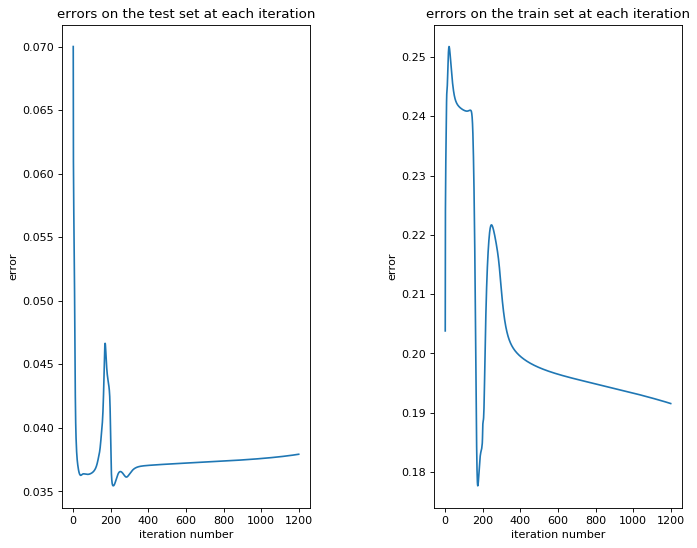

In [16]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.subplot(121)
plt.title("errors on the test set at each iteration")
plt.plot(iteration_number, test_errors)
plt.xlabel("iteration number")
plt.ylabel("error")

plt.subplot(122)
plt.title("errors on the train set at each iteration")
plt.plot(iteration_number, train_errors)
plt.xlabel("iteration number")
plt.ylabel("error")
plt.show()

## Tests in Train Set
In this section, there is no training but there is only prediction. Outputs for test set is predicted in order to be plotted as accurate or false in the next cell.

In [17]:
predictions = []
for j in range(len(train_inputs)):   # test with the test set
    prediction = network.predict(train_inputs[j])
    predictions.append(prediction)

In [18]:
t_test = []
f_test = []
for i in range(len(predictions)):
    if predictions[i] != train_outputs[i]:
        f_test.append(train_inputs[i])
    else:
        t_test.append(train_inputs[i])

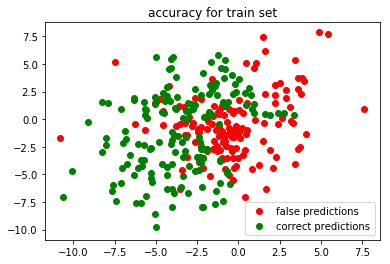

In [19]:
plt.scatter([x[0] for x in f_test], [x[1] for x in f_test], color='red', label='false predictions')
plt.scatter([x[0] for x in t_test], [x[1] for x in t_test], color='green', label='correct predictions')
plt.title('accuracy for train set')
plt.legend()
plt.show()

### tp - tn - fp - fn in Train Set
In this section, true positives, true negatives, false positives and false negatives for different classes are plotted.

In [20]:
train_tp_0 = []
train_tn_0 = []
train_fp_0 = []
train_fn_0 = []

train_tp_1 = []
train_tn_1 = []
train_fp_1 = []
train_fn_1 = []

train_tp_2 = []
train_tn_2 = []
train_fp_2 = []
train_fn_2 = []

In [21]:
for i in range(len(predictions)):
    if train_outputs[i] == [0,0]:
        if predictions[i] != train_outputs[i]:
            train_fn_0.append(train_inputs[i])
        else:
            train_tp_0.append(train_inputs[i])
            train_tn_1.append(train_inputs[i])
            train_tn_2.append(train_inputs[i])
    elif train_outputs[i] == [0,1]:
        if predictions[i] != train_outputs[i]:
            train_fn_1.append(train_inputs[i])
        else:
            train_tp_1.append(train_inputs[i]) 
            train_tn_0.append(train_inputs[i])
            train_tn_2.append(train_inputs[i])
    elif train_outputs[i] == [1,0]:
        if predictions[i] != train_outputs[i]:
            train_fn_2.append(train_inputs[i])
        else:
            train_tp_2.append(train_inputs[i])
            train_tn_0.append(train_inputs[i])
            train_tn_1.append(train_inputs[i])
    if predictions[i] == [0,0]:
        if predictions[i] != train_outputs[i]:
            train_fp_0.append(train_inputs[i])
    elif predictions[i] == [0,1]:
        if predictions[i] != train_outputs[i]:
            train_fp_1.append(train_inputs[i])
    elif predictions[i] == [1,0]:
        if predictions[i] != train_outputs[i]:
            train_fp_2.append(train_inputs[i])
        

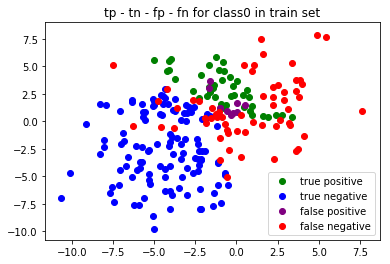

In [22]:
plt.scatter([x[0] for x in train_tp_0], [x[1] for x in train_tp_0], color='green', label='true positive')
plt.scatter([x[0] for x in train_tn_0], [x[1] for x in train_tn_0], color='blue', label='true negative')
plt.scatter([x[0] for x in train_fp_0], [x[1] for x in train_fp_0], color='purple', label='false positive')
plt.scatter([x[0] for x in train_fn_0], [x[1] for x in train_fn_0], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class0 in train set')
plt.show()

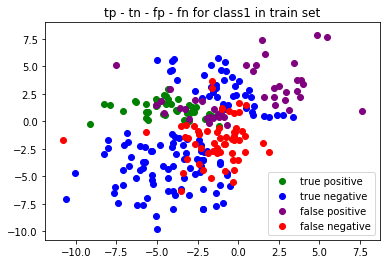

In [23]:
plt.scatter([x[0] for x in train_tp_1], [x[1] for x in train_tp_1], color='green', label='true positive')
plt.scatter([x[0] for x in train_tn_1], [x[1] for x in train_tn_1], color='blue', label='true negative')
plt.scatter([x[0] for x in train_fp_1], [x[1] for x in train_fp_1], color='purple', label='false positive')
plt.scatter([x[0] for x in train_fn_1], [x[1] for x in train_fn_1], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class1 in train set')
plt.show()

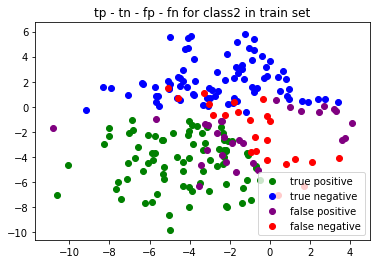

In [24]:
plt.scatter([x[0] for x in train_tp_2], [x[1] for x in train_tp_2], color='green', label='true positive')
plt.scatter([x[0] for x in train_tn_2], [x[1] for x in train_tn_2], color='blue', label='true negative')
plt.scatter([x[0] for x in train_fp_2], [x[1] for x in train_fp_2], color='purple', label='false positive')
plt.scatter([x[0] for x in train_fn_2], [x[1] for x in train_fn_2], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class2 in train set')
plt.show()

## Tests in Train Set
Tests on the test set. Again, there is no training, just testing with the current model.

In [25]:
predictions = []
for j in range(len(test_inputs)):   # test with the test set
    prediction = network.predict(test_inputs[j])
    predictions.append(prediction)

In [26]:
t_test = []
f_test = []
for i in range(len(predictions)):
    if predictions[i] != test_outputs[i]:
        f_test.append(test_inputs[i])
    else:
        t_test.append(test_inputs[i])

After the predictions have been completed for the test set, they are compared to the true outputs and labeled as correct or false. 

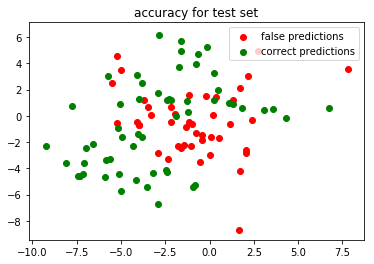

In [27]:
plt.scatter([x[0] for x in f_test], [x[1] for x in f_test], color='red', label='false predictions')
plt.scatter([x[0] for x in t_test], [x[1] for x in t_test], color='green', label='correct predictions')
plt.title('accuracy for test set')
plt.legend()
plt.show()

### tp - tn - fp - fn in Test Set
In this section, true positives, true negatives, false positives and false negatives for different classes are plotted.

In [31]:
test_tp_0 = []
test_tn_0 = []
test_fp_0 = []
test_fn_0 = []

test_tp_1 = []
test_tn_1 = []
test_fp_1 = []
test_fn_1 = []

test_tp_2 = []
test_tn_2 = []
test_fp_2 = []
test_fn_2 = []

In [32]:
for i in range(len(predictions)):
    if test_outputs[i] == [0,0]:
        if predictions[i] != test_outputs[i]:
            test_fn_0.append(test_inputs[i])
        else:
            test_tp_0.append(test_inputs[i])
            test_tn_1.append(test_inputs[i])
            test_tn_2.append(test_inputs[i])
    elif test_outputs[i] == [0,1]:
        if predictions[i] != test_outputs[i]:
            test_fn_1.append(test_inputs[i])
        else:
            test_tp_1.append(test_inputs[i]) 
            test_tn_0.append(test_inputs[i])
            test_tn_2.append(test_inputs[i])
    elif test_outputs[i] == [1,0]:
        if predictions[i] != test_outputs[i]:
            test_fn_2.append(test_inputs[i])
        else:
            test_tp_2.append(test_inputs[i])
            test_tn_0.append(test_inputs[i])
            test_tn_1.append(test_inputs[i])
    if predictions[i] == [0,0]:
        if predictions[i] != test_outputs[i]:
            test_fp_0.append(test_inputs[i])
    elif predictions[i] == [0,1]:
        if predictions[i] != test_outputs[i]:
            test_fp_1.append(test_inputs[i])
    elif predictions[i] == [1,0]:
        if predictions[i] != test_outputs[i]:
            test_fp_2.append(test_inputs[i])
        

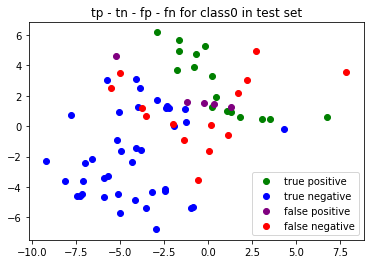

In [33]:
plt.scatter([x[0] for x in test_tp_0], [x[1] for x in test_tp_0], color='green', label='true positive')
plt.scatter([x[0] for x in test_tn_0], [x[1] for x in test_tn_0], color='blue', label='true negative')
plt.scatter([x[0] for x in test_fp_0], [x[1] for x in test_fp_0], color='purple', label='false positive')
plt.scatter([x[0] for x in test_fn_0], [x[1] for x in test_fn_0], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class0 in test set')
plt.show()

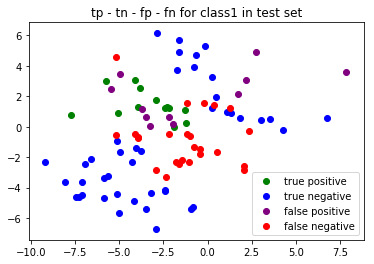

In [34]:
plt.scatter([x[0] for x in test_tp_1], [x[1] for x in test_tp_1], color='green', label='true positive')
plt.scatter([x[0] for x in test_tn_1], [x[1] for x in test_tn_1], color='blue', label='true negative')
plt.scatter([x[0] for x in test_fp_1], [x[1] for x in test_fp_1], color='purple', label='false positive')
plt.scatter([x[0] for x in test_fn_1], [x[1] for x in test_fn_1], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class1 in test set')
plt.show()

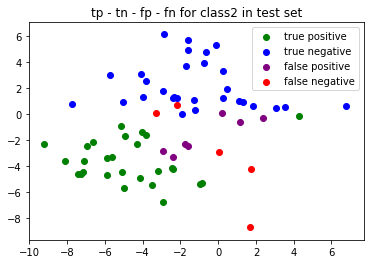

In [35]:
plt.scatter([x[0] for x in test_tp_2], [x[1] for x in test_tp_2], color='green', label='true positive')
plt.scatter([x[0] for x in test_tn_2], [x[1] for x in test_tn_2], color='blue', label='true negative')
plt.scatter([x[0] for x in test_fp_2], [x[1] for x in test_fp_2], color='purple', label='false positive')
plt.scatter([x[0] for x in test_fn_2], [x[1] for x in test_fn_2], color='red', label='false negative')
plt.legend()
plt.title('tp - tn - fp - fn for class2 in test set')
plt.show()